# Semantic Segmentation of satellite imagery using U-Net

## Step 2: Model building


In [ ]:
# Install necessary library
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet
!pip install segmentation-models-pytorch --quiet

In [2]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!pip install segmentation-models-pytorch torchmetrics albumentations --quiet

In [6]:
!pip uninstall torchvision -y
!pip install torchvision --index-url https://download.pytorch.org/whl/ --quiet

Found existing installation: torchvision 0.21.0
Uninstalling torchvision-0.21.0:
  Successfully uninstalled torchvision-0.21.0


In [1]:
# Set segmentation models to use PyTorch
import os
os.environ["SM_FRAMEWORK"] = "torch"

In [2]:
import os
import random
from pathlib import Path

import cv2
import numpy as np
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import albumentations as A  # Better augmentation for PyTorch
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
from torchmetrics import JaccardIndex  # IoU for PyTorch

c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
from torch.utils.data import Dataset, DataLoader
import cv2
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
# Define needed directory paths
dir_root = Path("../data/landcover_ai")

dir_train_img = Path(dir_root, "train_images/train/")
dir_train_mask = Path(dir_root, "train_masks/train/")
dir_val_img = Path(dir_root, "val_images/val/")
dir_val_mask = Path(dir_root, "val_masks/val/")

dir_models = Path("../data/models")




# Show how many image files exist
for dir in [dir_train_img, dir_train_mask, dir_val_img, dir_val_mask]:
    files = patch_files = [file for file in dir.iterdir()]
    print(f"{dir} has {len(files)} images.")

..\data\landcover_ai\train_images\train has 2250 images.
..\data\landcover_ai\train_masks\train has 2250 images.
..\data\landcover_ai\val_images\val has 750 images.
..\data\landcover_ai\val_masks\val has 750 images.


In [6]:
print(dir_root)
print(dir_models)
print(dir_train_img)

..\data\landcover_ai
..\data\models
..\data\landcover_ai\train_images\train


In [7]:
classes = {
    0: "Not classified",
    1: "Building",
    2: "Woodland",
    3: "Water",
    4: "Roads",
}

### Visualize random patch alongside its mask

img exists: ..\data\landcover_ai\train_images\train\M-34-65-D-a-4-4_patch_23_22.tif


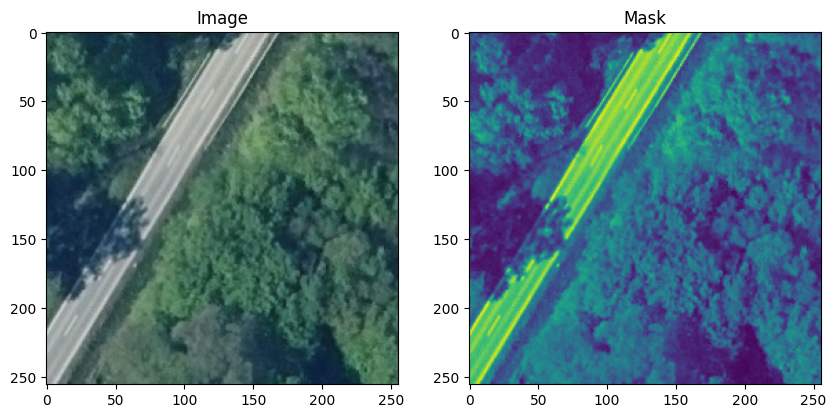

In [67]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

def plot_image_and_mask(image_path: Path, device="cuda"):
    """
    Function to plot an image alongside its mask, optimized for PyTorch and GPU.
    """
    if not image_path.exists():
        print(f"Error: Image file not found at {image_path}")
        return

    # Load and convert image
    img = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Error: Failed to load image {image_path}")
        return
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Generate corresponding mask path
    mask_path = Path(str(image_path).replace("/train_images/", "/train_masks/"))
    
    # Load mask as grayscale (single-channel)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Warning: Mask not found for {mask_path}")
        return

    # Convert image and mask to Torch Tensors
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    mask_tensor = torch.tensor(mask, dtype=torch.long).unsqueeze(0)  # Use float32 for visualization

    # Move tensors to GPU if available
    if torch.cuda.is_available():
        img_tensor = img_tensor.to(device)
        mask_tensor = mask_tensor.to(device)

    # Convert back to numpy for visualization
    img_np = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    mask_np = mask_tensor.squeeze(0).cpu().numpy()

    # Plot image and mask
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))

    axes[0].imshow(img_np)
    axes[0].set_title("Image")

    norm = mpl.colors.Normalize(vmin=mask_np.min(), vmax=mask_np.max())  # Dynamic scaling
    cmap = plt.get_cmap("viridis")

    axes[1].imshow(mask_np, cmap=cmap, norm=norm)
    axes[1].set_title("Mask")

    plt.show()

# Define image directory Update with the correct directory

# Define mask path correctly
img_path = Path("../data/landcover_ai/train_images/train/M-34-65-D-a-4-4_patch_23_22.tif")
print("img exists:", img_path)

# Call function to visualize
plot_image_and_mask(img_path)





In [72]:


img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
print(img_tensor)

mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask_tensor = torch.tensor(mask, dtype=torch.long).unsqueeze(0)  # Use float32 for visualization
print(mask_tensor)

# Convert back to numpy for visualization
img_np = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
mask_np = mask_tensor.squeeze(0).cpu().numpy()
print("image_np", img_np)
print("mask_np",mask_np)


tensor([[[[0.1922, 0.2706, 0.2667,  ..., 0.5216, 0.5255, 0.5098],
          [0.2157, 0.2314, 0.2196,  ..., 0.5137, 0.5020, 0.4784],
          [0.2275, 0.2392, 0.2196,  ..., 0.5059, 0.5020, 0.4902],
          ...,
          [0.4196, 0.3961, 0.3961,  ..., 0.4431, 0.4235, 0.3882],
          [0.4275, 0.3961, 0.3765,  ..., 0.4235, 0.3922, 0.3490],
          [0.4235, 0.4000, 0.3725,  ..., 0.4510, 0.4000, 0.3490]],

         [[0.2000, 0.2784, 0.2745,  ..., 0.4667, 0.4706, 0.4549],
          [0.2235, 0.2392, 0.2275,  ..., 0.4588, 0.4471, 0.4235],
          [0.2431, 0.2549, 0.2353,  ..., 0.4510, 0.4471, 0.4353],
          ...,
          [0.3725, 0.3490, 0.3569,  ..., 0.4118, 0.3922, 0.3569],
          [0.3804, 0.3490, 0.3373,  ..., 0.3922, 0.3608, 0.3176],
          [0.3765, 0.3529, 0.3333,  ..., 0.4196, 0.3686, 0.3176]],

         [[0.1490, 0.2275, 0.2235,  ..., 0.3294, 0.3255, 0.3098],
          [0.1725, 0.1882, 0.1765,  ..., 0.3216, 0.3020, 0.2784],
          [0.1882, 0.2000, 0.1804,  ..., 0

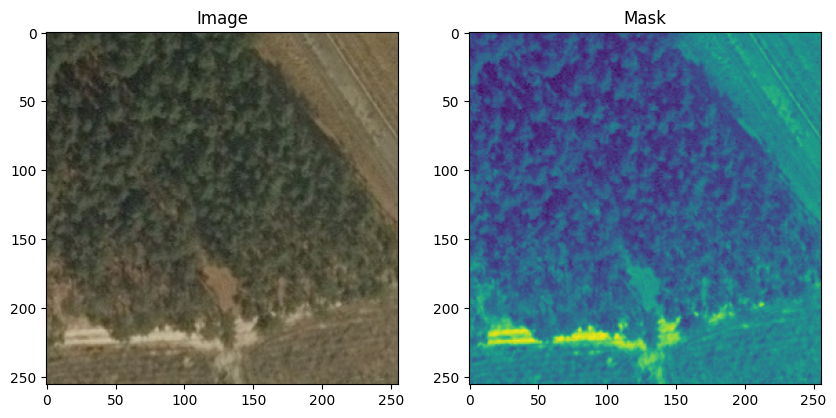

In [68]:
# Get paths of all images
img_files = list(dir_train_img.iterdir())

# Get random image from all images
img_path = random.choice(img_files)

# Plot with GPU support
# plot_image_and_mask(img_path, device="cuda")
plot_image_and_mask(img_path)

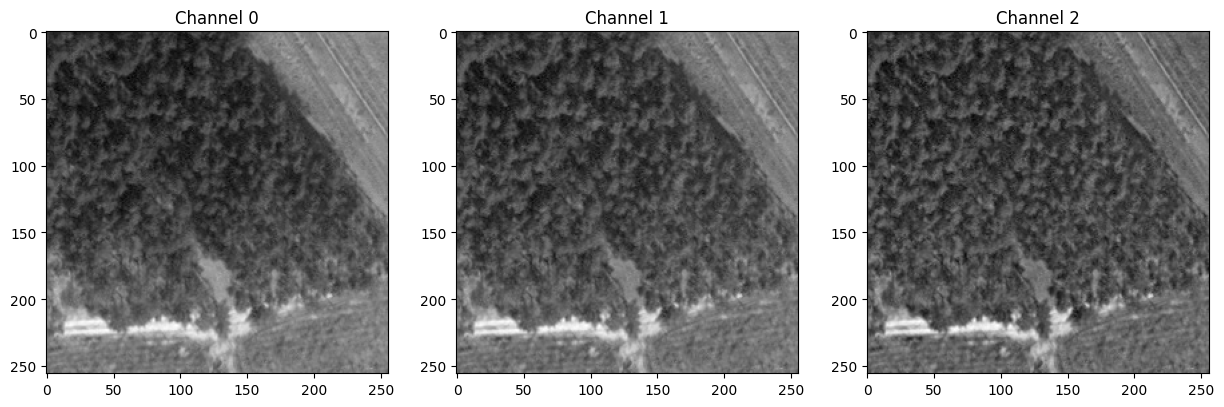

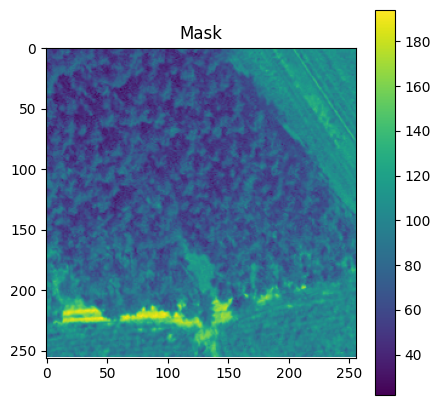

In [69]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Read the image correctly
temp_img = cv2.imread(str(img_path))  # Ensure it's read properly
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Plot each channel separately
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].imshow(temp_img[:, :, i], cmap="gray")
    axes[i].set_title(f"Channel {i}")

plt.show()

# Read the mask (should be grayscale)
mask_path = Path(str(img_path).replace("/train_images/", "/train_masks/"))
temp_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)  # Load as single-channel mask

if temp_mask is None:
    print(f"Error: Mask not found for {img_path}")
else:
    plt.figure(figsize=(5, 5))
    plt.imshow(temp_mask, cmap="viridis")
    plt.title("Mask")
    plt.colorbar()
    plt.show()

# Move to GPU if needed
if torch.cuda.is_available():
    temp_img_tensor = torch.tensor(temp_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    temp_mask_tensor = torch.tensor(temp_mask, dtype=torch.long).unsqueeze(0)

    temp_img_tensor = temp_img_tensor.to("cuda")
    temp_mask_tensor = temp_mask_tensor.to("cuda")

    print("Moved image and mask to GPU")





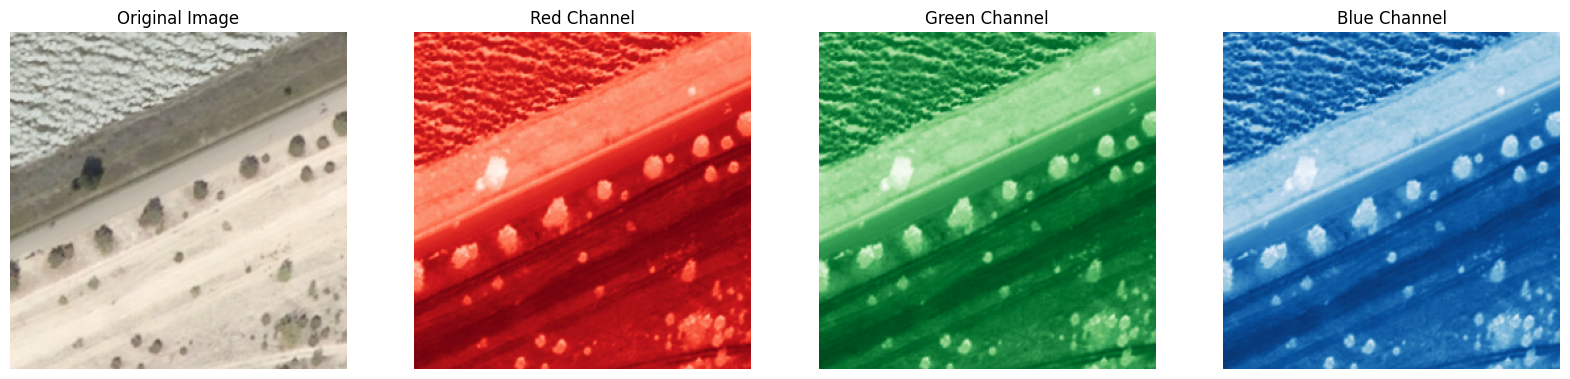

In [46]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def load_and_plot_image(img_path, device="cuda"):
    """
    Loads an image, splits RGB channels, and plots them with GPU support.
    """
    img_path = Path(img_path)  # Ensure it's a Path object

    # Load image safely
    img = cv2.imread(str(img_path))
    
    if img is None:
        print(f"Error: Image not found at {img_path}")
        return

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Split channels
    red_channel = img[:, :, 0]
    green_channel = img[:, :, 1]
    blue_channel = img[:, :, 2]

    # Convert to PyTorch tensor and move to GPU
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

    if torch.cuda.is_available():
        img_tensor = img_tensor.to(device)
        print("Image moved to GPU.")

    # Plot channels
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(red_channel, cmap="Reds")
    axs[1].set_title("Red Channel")
    axs[1].axis("off")

    axs[2].imshow(green_channel, cmap="Greens")
    axs[2].set_title("Green Channel")
    axs[2].axis("off")

    axs[3].imshow(blue_channel, cmap="Blues")
    axs[3].set_title("Blue Channel")
    axs[3].axis("off")

    plt.show()

# Example usage
load_and_plot_image(img_path)


In [47]:
import cv2
import torch
import numpy as np
from pathlib import Path

def analyze_mask(img_path, device="cuda"):
    """
    Loads the corresponding mask, checks unique labels, and moves to GPU if available.
    """
    img_path = Path(img_path)  # Ensure it's a Path object

    # Generate mask path dynamically
    mask_path = Path(str(img_path).replace("/train_images/", "/train_masks/"))

    if not mask_path.exists():
        print(f"Error: Mask not found for {img_path}")
        return

    # Load mask in grayscale mode
    temp_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    if temp_mask is None:
        print(f"Error: Failed to load mask {mask_path}")
        return

    # Convert to PyTorch tensor and move to GPU
    mask_tensor = torch.tensor(temp_mask, dtype=torch.long).unsqueeze(0)  # Keep as long for segmentation

    if torch.cuda.is_available():
        mask_tensor = mask_tensor.to(device)
        print("Mask moved to GPU.")

    # Analyze unique labels and their counts
    labels, counts = np.unique(temp_mask, return_counts=True)

    print("Labels are:", labels)
    print("Counts are:", counts)

    return labels, counts

# Example usage
analyze_mask(img_path)


Labels are: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245]
Counts are: [  2   6   2   4  10   5   8  16  10   9  12  15  11  10   9  15   5  10
   8   7  12   6   8   4  10   8   5   9   6   9   3  13   4  10   9  

(array([ 41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
        197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
        210, 211, 212, 213, 214, 215, 216, 217, 218

In [48]:
import numpy as np
import cv2
import torch
from pathlib import Path

def remap_mask(img_path, device="cuda"):
    """
    Loads the corresponding mask, remaps unique labels, and moves to GPU if available.
    """
    img_path = Path(img_path)  # Ensure it's a Path object

    # Generate mask path dynamically
    mask_path = Path(str(img_path).replace("/train_images/", "/train_masks/"))

    if not mask_path.exists():
        print(f"Error: Mask not found for {img_path}")
        return None

    # Load mask in grayscale mode
    temp_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    if temp_mask is None:
        print(f"Error: Failed to load mask {mask_path}")
        return None

    # Convert to PyTorch tensor
    mask_tensor = torch.tensor(temp_mask, dtype=torch.long)

    if torch.cuda.is_available():
        mask_tensor = mask_tensor.to(device)
        print("Mask moved to GPU.")

    # Find unique labels and their counts
    labels, counts = mask_tensor.unique(return_counts=True)

    print("Original Labels:", labels.cpu().numpy())  # Move to CPU for printing
    print("Counts:", counts.cpu().numpy())

    # Create a mapping dictionary to reassign labels to [0,1,2,...]
    label_mapping = {int(old_label): new_label for new_label, old_label in enumerate(labels.cpu().numpy())}

    # Apply mapping to mask
    remapped_mask = mask_tensor.clone()
    for old_label, new_label in label_mapping.items():
        remapped_mask[mask_tensor == old_label] = new_label

    # Find new unique labels after remapping
    new_labels, new_counts = remapped_mask.unique(return_counts=True)

    print("New Labels:", new_labels.cpu().numpy())
    print("New Counts:", new_counts.cpu().numpy())

    return remapped_mask

# Example usage
remapped_mask = remap_mask(img_path)


Original Labels: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245]
Counts: [  2   6   2   4  10   5   8  16  10   9  12  15  11  10   9  15   5  10
   8   7  12   6   8   4  10   8   5   9   6   9   3  13   4  10   9 

### Define Generator for images and masks

In [ ]:
import segmentation_models_pytorch as smp
import torch

# Set seed for reproducibility
seed = 24
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Define model parameters
batch_size = 16  # Lower to 8 if memory issues occur
n_classes = len(classes)
encoder_freeze = True

# Use this to preprocess input for transfer learning
BACKBONE = "resnet34"  # Correct name for PyTorch SMP

# PyTorch does not have `get_preprocessing()`, so we use transforms instead
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained="imagenet")

print(f"Using {BACKBONE} as backbone with {n_classes} classes.")


Using efficientnet-b5 as backbone with 5 classes.


In [51]:
print(n_classes)

5


In [74]:
import torch
import cv2
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
from pathlib import Path

# Load an example image and mask
img_path = Path("../data/landcover_ai/train_images/train/M-34-65-D-a-4-4_patch_23_22.tif")
mask_path = Path(str(img_path).replace("/train_images/", "/train_masks/"))

if not img_path.exists() or not mask_path.exists():
    raise FileNotFoundError(f"Image or mask not found: {img_path}, {mask_path}")

# Load image (Assuming it's RGB)
img = cv2.imread(str(img_path))  # Reads as BGR
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Load mask (Grayscale)
mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

# Convert to numpy array
img = np.array(img, dtype=np.float32)  # Ensure float32 for normalization
mask = np.array(mask, dtype=np.int64)  # Ensure int64 for PyTorch one-hot encoding

# Define number of classes
num_class = 5  # Adjust based on your dataset

def preprocess_data(img, mask, num_class, device="cuda"):
    """
    Function to perform additional preprocessing after data augmentation.
    """
    # Convert to PyTorch tensor
    img = torch.tensor(img, dtype=torch.float32)
    mask = torch.tensor(mask, dtype=torch.long)  # Ensure long for one-hot encoding

    # Normalize images to [0, 1]
    img = img / 255.0  # Equivalent to MinMax scaling

    # Apply preprocessing function (Mean & Std from ImageNet)
    preprocess = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = preprocess(img.permute(2, 0, 1))  # Convert to (C, H, W) format

    # Check unique values in mask
    unique_values = torch.unique(mask)
    print(f"Unique mask values before one-hot: {unique_values}")

    # Ensure mask values are within range [0, num_class-1]
    if unique_values.max() >= num_class:
        print(f"Warning: Mask contains values greater than or equal to num_class ({num_class}). Clamping values.")
        mask = torch.clamp(mask, 0, num_class - 1)

    # Convert mask to one-hot encoding
    mask = F.one_hot(mask, num_classes=num_class).permute(2, 0, 1)  # (H, W) → (C, H, W)

    # Move to GPU if available
    if torch.cuda.is_available():
        img = img.to(device)
        mask = mask.to(device)

    return img, mask

# Apply preprocessing
img_tensor, mask_tensor = preprocess_data(img, mask, num_class)

print(f"Processed Image Shape: {img_tensor.shape}")  # Should be (3, H, W)
print(f"Processed Mask Shape: {mask_tensor.shape}")  # Should be (num_class, H, W)


Unique mask values before one-hot: tensor([ 26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
        194, 195, 196, 197, 1

In [ ]:
import torch
import cv2
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
import albumentations as A  # For augmentations
from albumentations.pytorch import ToTensorV2

# Define augmentation transforms
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Define dataset class
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, num_class, transform=None):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.img_files = list(self.img_dir.glob("*.tif"))  # Adjust file extension if needed
        self.num_class = num_class
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = Path(str(img_path).replace("/train_images/", "/train_masks/"))

        # Load image
        img = cv2.imread(str(img_path))  # Reads as BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Load mask (grayscale)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        # Ensure correct datatype
        img = np.array(img, dtype=np.float32)  # Keep float32 for normalization
        mask = np.array(mask, dtype=np.int64)  # Ensure int64 for PyTorch one-hot

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]

        # Convert mask to one-hot encoding
        mask = F.one_hot(torch.tensor(mask, dtype=torch.long), num_classes=self.num_class)
        mask = mask.permute(2, 0, 1)  # Convert to (C, H, W)

        return img, mask

# Define DataLoader function
def trainGenerator(train_img_path, train_mask_path, num_class, batch_size=16):
    dataset = SegmentationDataset(train_img_path, train_mask_path, num_class, transform=train_transforms)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    return train_loader

# Example usage
train_loader = trainGenerator(dir_train_img,dir_train_mask,num_class=5)

# Get a batch
for img_batch, mask_batch in train_loader:
    print(f"Image batch shape: {img_batch.shape}")  # Should be (batch_size, 3, H, W)
    print(f"Mask batch shape: {mask_batch.shape}")  # Should be (batch_size, num_classes, H, W)
    break


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import cv2
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, num_classes, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.image_paths = sorted(list(self.image_dir.glob("*.tif")))
        self.mask_paths = sorted(list(self.mask_dir.glob("*.tif")))
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Read image
        img = cv2.imread(str(self.image_paths[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0  # Normalize

        # Read mask
        mask = cv2.imread(str(self.mask_paths[idx]), cv2.IMREAD_GRAYSCALE).astype(np.int64)

        # Convert mask to one-hot encoding
        mask = torch.as_tensor(mask, dtype=torch.long)
        mask = torch.nn.functional.one_hot(mask, num_classes=self.num_classes).permute(2, 0, 1)

        # Convert to PyTorch tensors
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # [H, W, C] → [C, H, W]

        return img, mask


In [ ]:
from torch.utils.data import DataLoader

# Define needed directory paths
DIRS = {
    "root": "..data/landcover_ai/",
    "train_img": "..data/landcover_ai/train_images/train/",
    "train_mask": "..data/landcover_ai/train_masks/train/",
    "val_img": "..data/landcover_ai/val_images/val/",
    "val_mask": "..data/landcover_ai/val_masks/val/"
}

# Create DataLoader for Training and Validation
train_loader = DataLoader(
    CustomDataset(DIRS["train_img"], DIRS["train_mask"], num_classes=n_classes),
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    CustomDataset(DIRS["val_img"], DIRS["val_mask"], num_classes=n_classes),
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [21]:
print(train_img_gen)
print(val_img_gen)

<generator object trainGenerator at 0x000001986360A3E0>
<generator object trainGenerator at 0x000001986360A510>


### Visualize some images to check

Make sure the generator is working and that images and masks are indeed lined up.

Found 2250 images belonging to 1 classes.
Found 2250 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


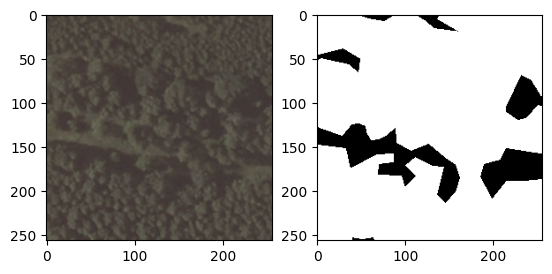

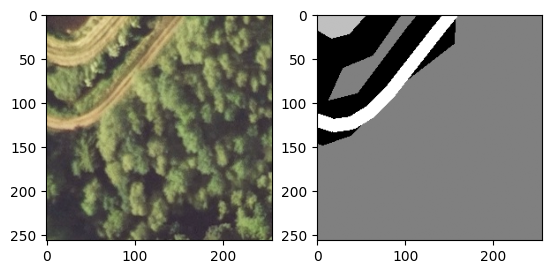

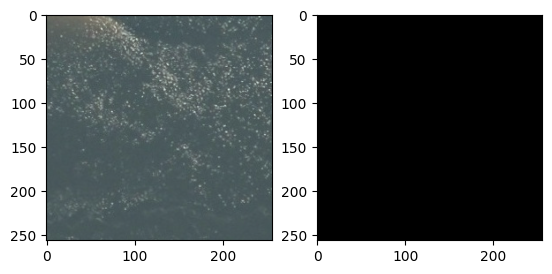

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Get next batch of images and masks
x, y = next(iter(train_loader))

# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x, y = x.to(device), y.to(device)

print(f"Image batch shape: {x.shape}")  # (batch_size, 3, height, width)
print(f"Mask batch shape (before argmax): {y.shape}")  # (batch_size, num_classes, height, width)

# Convert one-hot mask to categorical mask (single-channel)
y = torch.argmax(y, dim=1)  # Now shape is (batch_size, height, width)

print(f"Mask batch shape (after argmax): {y.shape}")  # (batch_size, height, width)

# Ensure x has 3 channels (RGB)
assert x.shape[1] == 3, "Expected 3 channels (RGB) in images"

# Ensure y has correct shape
assert len(y.shape) == 3, "Masks should have shape (batch_size, height, width)"

# Plot the first 3 images and masks
for i in range(3):
    image = x[i].permute(1, 2, 0).cpu().numpy()  # Convert from (C, H, W) to (H, W, C)
    mask = y[i].cpu().numpy()  # Now mask is (H, W) with class indices

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.show()


Found 750 images belonging to 1 classes.
Found 750 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


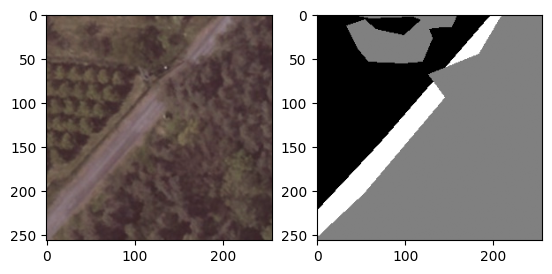

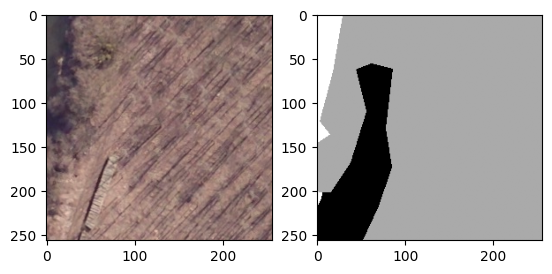

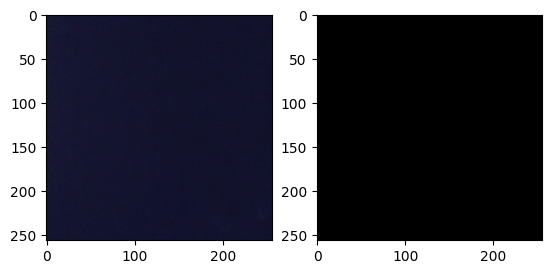

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Get the next batch of validation images and masks
x_val, y_val = next(iter(val_loader))

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_val, y_val = x_val.to(device), y_val.to(device)

print(f"Validation Image batch shape: {x_val.shape}")  # (batch_size, 3, H, W)
print(f"Validation Mask batch shape (before argmax): {y_val.shape}")  # (batch_size, num_classes, H, W)

# Convert one-hot mask to categorical labels
y_val = torch.argmax(y_val, dim=1)  # Now (batch_size, H, W)

print(f"Validation Mask batch shape (after argmax): {y_val.shape}")  # (batch_size, H, W)

# Ensure x_val has 3 channels (RGB)
assert x_val.shape[1] == 3, "Expected 3 channels (RGB) in images"

# Ensure y_val has correct shape
assert len(y_val.shape) == 3, "Masks should have shape (batch_size, height, width)"

# Plot the first 3 images and masks
for i in range(3):
    image = x_val[i].permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) → (H, W, C)
    mask = y_val[i].cpu().numpy()  # Convert tensor to NumPy (H, W)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Validation Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Validation Mask")
    plt.axis("off")

    plt.show()


### Define the model metrics and load model

In [ ]:
# Count the number of training and validation images
num_train_imgs = sum(1 for file in dir_train_img.iterdir() if file.is_file())
num_val_images = sum(1 for file in dir_val_img.iterdir() if file.is_file())

# Define batch size
batch_size = 8  # Adjust based on memory

# Compute steps per epoch
steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_images // batch_size

# Extract image dimensions from a batch
sample_batch, _ = next(iter(train_loader))  # Get a sample batch from DataLoader

# Extract dimensions (PyTorch uses [batch_size, channels, height, width])
IMG_CHANNELS = sample_batch.shape[1]  # Channels (should be 3 for RGB)
IMG_HEIGHT = sample_batch.shape[2]  # Height
IMG_WIDTH = sample_batch.shape[3]  # Width



# Print results
print(f"Training Images: {num_train_imgs}, Validation Images: {num_val_images}")
print(f"Image Shape: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {val_steps_per_epoch}")


In [ ]:
# Number of training epochs
EPOCHS = 10

In [25]:
print(num_train_imgs)
print(num_val_images)
print(steps_per_epoch)
print(val_steps_per_epoch)

2250
750
140
46


### Use transfer learning using pretrained encoder in the U-Net

We use ***Intersection over Union (IoU)*** as evaluation metric (see [here](https://towardsdatascience.com/iou-a-better-detection-evaluation-metric-45a511185be1)). is used when calculating Mean average precision (mAP). It is a number from 0 to 1 that specifies the amount of overlap between the predicted and ground truth bounding box:

- an IoU of 0 means that there is no overlap between the boxes
- an IoU of 1 means that the union of the boxes is the same as their overlap indicating that they are completely overlapping

In [ ]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
model = smp.Unet(
    encoder_name=BACKBONE,  # EfficientNet backbone
    encoder_weights="imagenet",  # Use pre-trained weights
    encoder_depth=5,
    decoder_channels=(256, 128, 64, 32, 16),
    in_channels=IMG_CHANNELS,  # 3 for RGB
    classes=len(classes),  # Number of output segmentation classes
    activation=None,  # No activation because we'll use CrossEntropyLoss
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function (using smp's Jaccard loss)
loss_fn = smp.losses.JaccardLoss(mode="multiclass")

# Define optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define IoU metric function
def iou_score(y_true, y_pred):
    """Compute IoU score using PyTorch."""
    intersection = (y_true & y_pred).float().sum((1, 2))  # Element-wise AND
    union = (y_true | y_pred).float().sum((1, 2))  # Element-wise OR
    return (intersection + 1e-6) / (union + 1e-6)  # Avoid division by zero

# Print model summary
print(model)

# Print input shape (PyTorch uses [batch_size, channels, height, width])
print(f"Model Input Shape: {IMG_CHANNELS}x{IMG_HEIGHT}x{IMG_WIDTH}")


171164896/171164896 ━━━━━━━━━━━━━━━━━━━━ 34s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, 64, 64,    │          0 │ stage1_unit1_bn3

 Total params: 51,606,046 (196.86 MB)

 Trainable params: 9,111,448 (34.76 MB)

 Non-trainable params: 42,494,598 (162.10 MB)

None
(None, 256, 256, 3)


In [ ]:
!pip install torchviz torchinfo --quiet

In [ ]:
from torchviz import make_dot
import torch

# Generate a random input tensor (batch size = 1)
sample_input = torch.randn(1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH).to(device)

# Get model output
output = model(sample_input)

# Generate the computational graph
dot = make_dot(output, params=dict(model.named_parameters()))

# Save and display the model architecture
dot.format = "png"
dot.render("model_architecture")

# Display in notebook (if using Jupyter)
from IPython.display import Image
Image("model_architecture.png")


In [ ]:
from torchinfo import summary

# Print model architecture summary
summary(model, input_size=(1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))


In [ ]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

class EarlyStopping:
    """Early stops the training if validation IoU does not improve after a given patience."""
    def __init__(self, patience=7, verbose=True, mode='max', delta=0.0001):
        self.patience = patience
        self.verbose = verbose
        self.mode = mode
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_score, model, path="best_model.pth"):
        score = val_score if self.mode == 'max' else -val_score

        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.counter = 0
            torch.save(model.state_dict(), path)  # Save best model
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# Example Usage:
early_stopping = EarlyStopping(patience=7, verbose=True, mode='max')

# Learning rate scheduler (optional)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)

"""# Inside Training Loop:
for epoch in range(EPOCHS):
    train(...)
    val_iou_score = validate(...)  # Compute validation IoU
    early_stopping(val_iou_score, model)

    # Reduce learning rate if IoU doesn't improve
    scheduler.step(val_iou_score)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break"""


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
from tqdm import tqdm
import segmentation_models_pytorch as smp

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model with reduced encoder depth
model = smp.Unet(
    encoder_name=BACKBONE,
    encoder_weights="imagenet",
    encoder_depth=4,  # Reduced depth for faster training
    decoder_channels=(256, 128, 64, 32),
    in_channels=IMG_CHANNELS,
    classes=len(classes),
    activation=None,
).to(device)

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Enable mixed precision
scaler = torch.cuda.amp.GradScaler()

# Training Function
def train_one_epoch(model, train_loader, optimizer, criterion, device, accumulation_steps=2):
    model.train()
    running_loss = 0.0
    train_loader = tqdm(train_loader, total=min(len(train_loader), 500), desc="Training")  # Limit steps per epoch

    optimizer.zero_grad()
    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(images)
            if masks.ndim == 4:
                masks = torch.argmax(masks, dim=1)
            loss = criterion(outputs, masks.long()) / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:  # Update after accumulation steps
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item()
        if i >= 500: break  # Limit training steps per epoch
        train_loader.set_description(f"Loss: {loss.item():.4f}")

    return running_loss / len(train_loader)

# Validation Function
@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss, iou_scores = 0.0, []

    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        if masks.ndim == 4:
            masks = torch.argmax(masks, dim=1)

        val_loss += criterion(outputs, masks.long()).item()
        iou_scores.append(compute_iou(outputs, masks))

    return val_loss / len(val_loader), sum(iou_scores) / len(iou_scores)

# Compute IoU
def compute_iou(outputs, masks):
    preds = torch.argmax(outputs, dim=1)
    intersection = (preds & masks).sum().item()
    union = (preds | masks).sum().item()
    return intersection / (union + 1e-6)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience, self.counter, self.best_score, self.early_stop = patience, 0, None, False
        self.verbose = verbose

    def __call__(self, val_score, model, path="best_model.pth"):
        if self.best_score is None or val_score > self.best_score:
            self.best_score, self.counter = val_score, 0
            torch.save(model.state_dict(), path)
            if self.verbose: print(f"Model saved at {path}")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered.")

early_stopping = EarlyStopping()

'''# Training Loop
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_iou_score = validate(model, val_loader, criterion, device)

    early_stopping(val_iou_score, model, path="best_model.pth")

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val IoU: {val_iou_score:.4f}")

    if early_stopping.early_stop:
        break

# Save Final Model
torch.save(model.state_dict(), f"final_model.pth")
print("Final model saved!")'''

# --- Initialize Metrics for Plotting ---
train_losses, val_losses = [], []
train_ious, val_ious = [], []

# --- Training Loop ---
for epoch in range(EPOCHS):
    train_loss, train_iou = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_iou_score = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou_score)

    early_stopping(val_iou_score, model, path="best_model.pth")

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Train IoU: {train_iou:.4f} - Val IoU: {val_iou_score:.4f}")

    if early_stopping.early_stop:
        break

# Save Final Model
torch.save(model.state_dict(), f"final_model.pth")
print("Final model saved!")


Epoch 1/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 1151s 8s/step - custom_iou_score: 0.3246 - loss: 0.7103 - val_custom_iou_score: 0.0769 - val_loss: 1.1439
Epoch 2/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1039s 7s/step - custom_iou_score: 0.5504 - loss: 0.4841 - val_custom_iou_score: 0.0741 - val_loss: 1.2948
Epoch 3/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 919s 7s/step - custom_iou_score: 0.5915 - loss: 0.4395 - val_custom_iou_score: 0.0751 - val_loss: 1.3715
Epoch 4/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 818s 6s/step - custom_iou_score: 0.6277 - loss: 0.4008 - val_custom_iou_score: 0.0735 - val_loss: 1.3884
Epoch 5/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 792s 6s/step - custom_iou_score: 0.6498 - loss: 0.3759 - val_custom_iou_score: 0.0822 - val_loss: 1.3484
Epoch 6/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 803s 6s/step - custom_iou_score: 0.6586 - loss: 0.3668 - val_custom_iou_score: 0.1291 - val_loss: 1.1374
Epoch 7/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 796s 6s/step - custom_iou_score: 0.6805 - loss: 0.3444 - val_custom_iou_score: 0.3649 - val_loss: 0.7112
Epoch 8/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 789s 6s/step - custom_iou_score: 0.6782 - loss: 0.3465 - val_custom_iou_score: 0.5465 - val_loss: 0.4941
Epoch 9/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 791s 6s/step - custom_iou_score: 0.6874 - loss: 0.3357 - val_custom_iou_score: 0.6497 - val_loss: 0.3758
Epoch 10/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 929s 7s/step - custom_iou_score: 0.6904 - loss: 0.3321 - val_custom_iou_score: 0.6636 - val_loss: 0.3604
Epoch 11/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1526s 11s/step - custom_iou_score: 0.7075 - loss: 0.3148 - val_custom_iou_score: 0.6787 - val_loss: 0.3481
Epoch 12/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1480s 11s/step - custom_iou_score: 0.7058 - loss: 0.3172 - val_custom_iou_score: 0.6727 - val_loss: 0.3502
Epoch 13/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 934s 7s/step - custom_iou_score: 0.7042 - loss: 0.3179 - val_custom_iou_score: 0.6750 - val_loss: 0.3510
Epoch 14/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 903s 6s/step - custom_iou_score: 0.7271 - loss: 0.2931 - val_custom_iou_score: 0.6946 - val_loss: 0.3267
Epoch 15/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 825s 6s/step - custom_iou_score: 0.7206 - loss: 0.3009 - val_custom_iou_score: 0.6979 - val_loss: 0.3240
Epoch 16/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 805s 6s/step - custom_iou_score: 0.7206 - loss: 0.3001 - val_custom_iou_score: 0.7053 - val_loss: 0.3155
Epoch 17/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 805s 6s/step - custom_iou_score: 0.7097 - loss: 0.3113 - val_custom_iou_score: 0.6994 - val_loss: 0.3217
Epoch 18/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 806s 6s/step - custom_iou_score: 0.7445 - loss: 0.2743 - val_custom_iou_score: 0.7185 - val_loss: 0.3042
Epoch 19/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 836s 6s/step - custom_iou_score: 0.7405 - loss: 0.2801 - val_custom_iou_score: 0.7167 - val_loss: 0.3072
Epoch 20/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 826s 6s/step - custom_iou_score: 0.7365 - loss: 0.2834 - val_custom_iou_score: 0.6892 - val_loss: 0.3372
Epoch 21/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 803s 6s/step - custom_iou_score: 0.7311 - loss: 0.2896 - val_custom_iou_score: 0.7141 - val_loss: 0.3056
Epoch 22/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 806s 6s/step - custom_iou_score: 0.7385 - loss: 0.2807 - val_custom_iou_score: 0.7270 - val_loss: 0.2956
Epoch 23/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 802s 6s/step - custom_iou_score: 0.7452 - loss: 0.2749 - val_custom_iou_score: 0.7261 - val_loss: 0.2955
Epoch 24/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 805s 6s/step - custom_iou_score: 0.7412 - loss: 0.2767 - val_custom_iou_score: 0.7144 - val_loss: 0.3063
Epoch 25/25


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 808s 6s/step - custom_iou_score: 0.7593 - loss: 0.2585 - val_custom_iou_score: 0.7172 - val_loss: 0.3017


c:\Users\debas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


In [ ]:
import torch
from pathlib import Path

# Save the final model
final_model_path = dir_models / "final_model.pth"
torch.save(model.state_dict(), final_model_path)

print(f"Final model saved at: {final_model_path}")

### Plot training and validation IoU and loss at each epoch

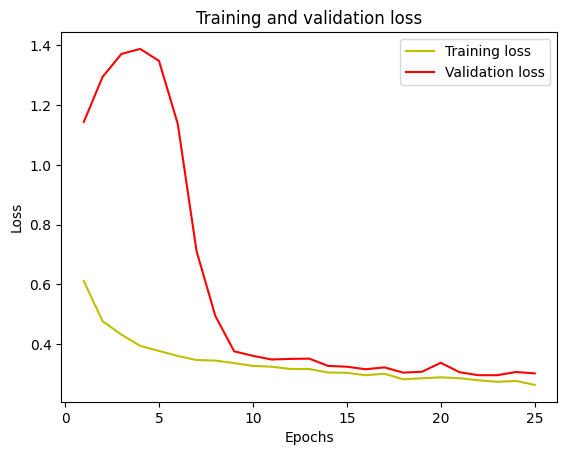

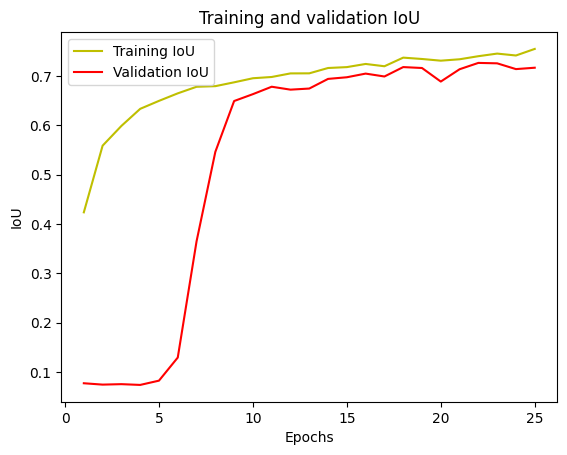

In [ ]:
# --- Plot Training & Validation Metrics ---
epochs = list(range(1, len(train_losses) + 1))

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, "y", label="Training Loss")
plt.plot(epochs, val_losses, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation IoU
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_ious, "y", label="Training IoU")
plt.plot(epochs, val_ious, "r", label="Validation IoU")
plt.title("Training and Validation IoU Score")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.legend()
plt.grid()
plt.show()

### Evaulate model on test data

In [ ]:
import torch
import numpy as np
from torchmetrics import JaccardIndex  # PyTorch IoU metric
import segmentation_models_pytorch as smp



# Load saved model weights
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# Get test batch
test_images, test_masks = next(iter(val_loader))  # Get a batch from validation set
test_images, test_masks = test_images.to(device), test_masks.to(device)

# Forward pass (Inference)
with torch.no_grad():
    test_preds = model(test_images)

# Convert predictions & masks to class indices
test_preds_argmax = torch.argmax(test_preds, dim=1)
test_masks_argmax = torch.argmax(test_masks, dim=1) if test_masks.ndim == 4 else test_masks

# Compute IoU using PyTorch Metrics
iou_metric = JaccardIndex(task="multiclass", num_classes=classes).to(device)
iou_score = iou_metric(test_preds_argmax, test_masks_argmax)

print(f"✅ Mean IoU = {iou_score.item():.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Mean IoU = 0.62514997


## Calculation

- Accuracy is typically used for classification tasks, where the goal is to predict discrete classes. In semantic segmentation, accuracy measures the percentage of pixels that are correctly classified.

- R-squared (R2) is commonly used in regression problems to measure the goodness of fit. It's less relevant in semantic segmentation, which is primarily a classification task.
- Mean Squared Error (MSE) is a regression metric that quantifies the average squared difference between predicted and true values. In semantic segmentation, it can be applied to the pixel-wise probabilities or class labels. However, it might not be the most informative metric for this task.
- Loss is the function used to optimize the model during training. In semantic segmentation, various loss functions can be employed, such as categorical cross-entropy or Dice loss. The loss value reflects the model's overall performance during training.

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torchmetrics import Accuracy, MeanSquaredError

# Load trained model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# Get test batch
test_images, test_masks = next(iter(val_loader))
test_images, test_masks = test_images.to(device), test_masks.to(device)

# Forward pass (Inference)
with torch.no_grad():
    test_preds = model(test_images)

# Convert predictions to class indices
test_preds_argmax = torch.argmax(test_preds, dim=1)  # (B, H, W)
test_masks_argmax = torch.argmax(test_masks, dim=1) if test_masks.ndim == 4 else test_masks  # (B, H, W)

# Compute Accuracy
accuracy_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
accuracy = accuracy_metric(test_preds_argmax, test_masks_argmax)

# Compute Mean Squared Error (MSE)
mse_metric = MeanSquaredError().to(device)
mse = mse_metric(test_preds.float(), F.one_hot(test_masks_argmax, NUM_CLASSES).permute(0, 3, 1, 2).float())

# Compute R-squared (R²) Score
y_true_flat = test_masks.cpu().numpy().flatten()
y_pred_flat = test_preds.cpu().numpy().flatten()
r2 = np.corrcoef(y_true_flat, y_pred_flat)[0, 1] ** 2  # R² using correlation

# Print metrics
print(f"Accuracy: {accuracy.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")
print(f"R² Score: {r2:.4f}")


Loss: 0.26300740242004395
Mean Squared Error: 0.4561147689819336
Accuracy: 0.9260177612304688
R-squared: 0.8379919445927578


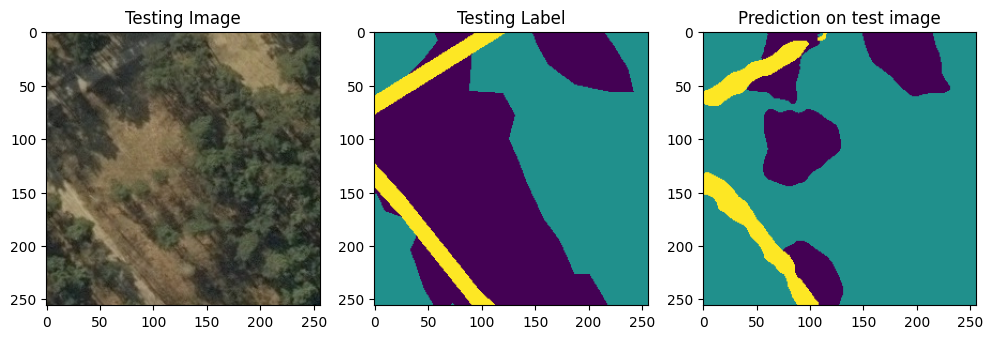

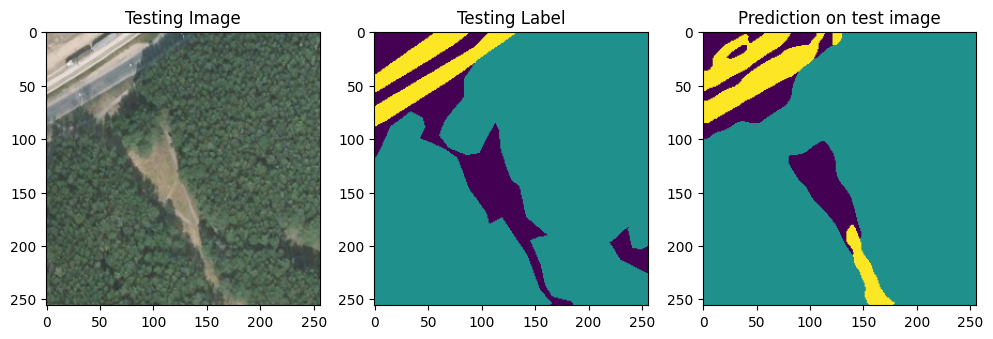

In [ ]:
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define class labels and corresponding colors (Adjust as needed)
class_labels = {
    0: "Background",
    1: "Building",
    2: "Road",
    3: "Water",
    4: "Vegetation",
}
num_classes = len(class_labels)

# Generate a color map for visualization
color_palette = sns.color_palette("husl", num_classes)  # Unique colors per class
class_colors = {k: np.array(v) for k, v in zip(class_labels.keys(), color_palette)}

# Function to colorize segmentation masks
def colorize_mask(mask):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3))  # Create an empty RGB mask
    for cls_id, color in class_colors.items():
        color_mask[mask == cls_id] = color  # Apply color to corresponding pixels
    return color_mask

# Get test batch
test_images, test_masks = next(iter(val_loader))
test_images, test_masks = test_images.to(device), test_masks.to(device)

# Forward pass (Inference)
with torch.no_grad():
    test_preds = model(test_images)

# Convert predictions & ground truth to class indices
test_preds_argmax = torch.argmax(test_preds, dim=1).cpu().numpy()  # (B, H, W)
test_masks_argmax = torch.argmax(test_masks, dim=1).cpu().numpy() if test_masks.ndim == 4 else test_masks.cpu().numpy()  # (B, H, W)

# Select a random image
img_num = random.randint(0, test_images.shape[0] - 1)

# Convert tensor image to NumPy for visualization
test_image_np = test_images[img_num].cpu().numpy().transpose(1, 2, 0)  # (H, W, C)

# Convert masks to colorized versions
test_mask_color = colorize_mask(test_masks_argmax[img_num])
test_pred_color = colorize_mask(test_preds_argmax[img_num])

# Plot images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Testing Image")
plt.imshow(test_image_np)

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(test_mask_color)

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(test_pred_color)

# Create a legend with class colors
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in class_colors.values()]
plt.figlegend(legend_patches, class_labels.values(), loc="lower center", ncol=num_classes, fontsize=10)

plt.show()
